<img src="http://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_torchtrt_efficientnet/nvidia_logo.png" width="90px">

# Pyspark TensorFlow Inference

### Text Classification
In this notebook, we demonstrate training a model to perform sentiment analysis, and using the trained model for distributed inference.  
Based on: https://www.tensorflow.org/tutorials/keras/text_classification

Note that cuFFT/cuDNN/cuBLAS registration errors are expected with `tf=2.17.0` and will not affect behavior, as noted in [this issue.](https://github.com/tensorflow/tensorflow/issues/62075)  

In [1]:
import os
import re
import shutil
import string
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, losses

2024-12-13 16:53:15.312368: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 16:53:15.319845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 16:53:15.327793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 16:53:15.330282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 16:53:15.336423: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.17.0


### Download and explore the dataset

In [3]:
import pathlib
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    fname="aclImdb", origin=url, untar=True,
)

dataset_dir = pathlib.Path(dataset)

In [4]:
# aclImdb might be created as a directory containing a single directory aclImdb. Check if this is the case:
if os.path.exists(dataset_dir / "aclImdb"):
    dataset_dir = dataset_dir / "aclImdb"

In [5]:
os.listdir(dataset_dir)

['README', 'imdb.vocab', 'test', 'train', 'imdbEr.txt']

In [6]:
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")
os.listdir(train_dir)

['pos',
 'labeledBow.feat',
 'urls_pos.txt',
 'neg',
 'urls_unsup.txt',
 'unsupBow.feat',
 'urls_neg.txt']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [7]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset
Next, we will load the data off disk and prepare it into a format suitable for training. To do so, we will use the helpful text_dataset_from_directory utility.

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2024-12-13 16:53:16.581193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46068 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


There are 25,000 examples in the training folder, of which we will use 80% (or 20,000) for training. We can also iterate over the dataset and print out a few examples.

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2024-12-13 16:53:17.034527: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice the reviews contain raw text (with punctuation and occasional HTML tags like \<br/>\). We will show how to handle these in the following section.

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, we will create a validation and test dataset. We will use the remaining 5,000 reviews from the training set for validation.

In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, we will standardize, tokenize, and vectorize the data using the tf.keras.layers.TextVectorization layer.  
We will write a custom standardization function to remove the HTML.

In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

Next, we will create a TextVectorization layer to standardize, tokenize, and vectorize our data.

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-12-13 16:53:18.999555: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's create a function to see the result of using this layer to preprocess some data.

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

We can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

#### Train model

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1734108799.625408 3762232 service.cc:146] XLA service 0x757cbc009260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734108799.625428 3762232 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-12-13 16:53:19.638685: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-13 16:53:19.701970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


234/625 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - binary_accuracy: 0.5330 - loss: 0.6901

I0000 00:00:1734108800.211333 3762232 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.5822 - loss: 0.6808 - val_binary_accuracy: 0.7354 - val_loss: 0.6104
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - binary_accuracy: 0.7602 - loss: 0.5771 - val_binary_accuracy: 0.8082 - val_loss: 0.4980
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - binary_accuracy: 0.8228 - loss: 0.4652 - val_binary_accuracy: 0.8356 - val_loss: 0.4237
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - binary_accuracy: 0.8522 - loss: 0.3925 - val_binary_accuracy: 0.8444 - val_loss: 0.3840
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - binary_accuracy: 0.8681 - loss: 0.3470 - val_binary_accuracy: 0.8492 - val_loss: 0.3603
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - binary_accuracy: 0.8817 - loss: 0.3152 - val_binary_accuracy: 0.8554 - val_loss: 0.3410
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - binary_accuracy: 0.8910 - loss: 0.2891 - val_binary_accuracy: 0.8564 - val_loss: 0.3318
Epoch

#### Evaluate the model

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - binary_accuracy: 0.8750 - loss: 0.3262

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - binary_accuracy: 0.8555 - loss: 0.3312
Loss:  0.3320814371109009
Accuracy:  0.8556399941444397


Create a plot of accuracy and loss over time:

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

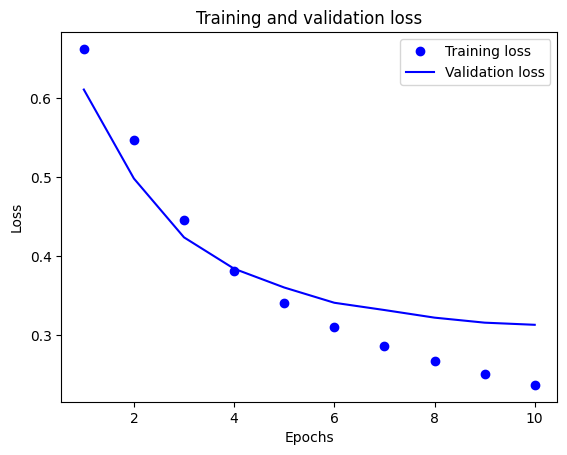

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

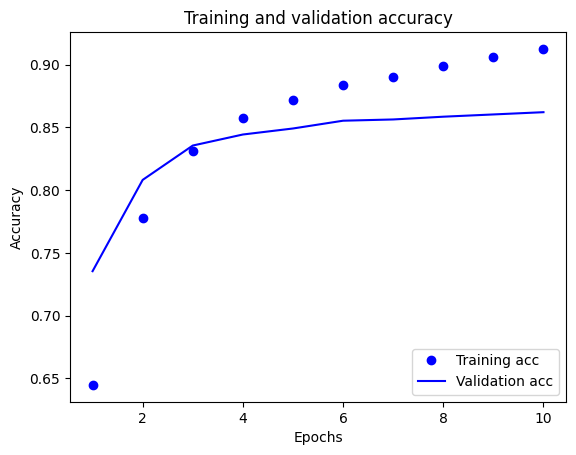

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export the model

We can export the model including the TextVectorization layer inside the model to conduct inference on raw text.

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

 57/782 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4908 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4976 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.5000399947166443, 'binary_accuracy': 0.0, 'loss': 0.0}


Conduct inference on new data:

In [30]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.58123446],
       [0.5467861 ],
       [0.533478  ]], dtype=float32)

### Save Model

In [31]:
os.mkdir('models') if not os.path.exists('models') else None

In [32]:
export_model.save('models/text_model.keras')

### Load model

In [33]:
# register callables as custom objects before loading
custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('models/text_model.keras', compile=False)

new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       160,017 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,017 (625.07 KB)

 Trainable params: 160,017 (625.07 KB)

 Non-trainable params: 0 (0.00 B)

### Predict

In [34]:
new_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


array([[0.58123446],
       [0.5467861 ],
       [0.533478  ]], dtype=float32)

## PySpark

In [ ]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array, pandas_udf
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pandas as pd
import json

Check the cluster environment to handle any platform-specific Spark configurations.

In [36]:
on_databricks = os.environ.get("DATABRICKS_RUNTIME_VERSION", False)
on_dataproc = os.environ.get("DATAPROC_VERSION", False)
on_standalone = not (on_databricks or on_dataproc)

In [37]:
conf = SparkConf()

if on_standalone:
    conda_env = os.environ.get("CONDA_PREFIX")
    # Point PyTriton to correct libpython3.11.so:
    conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_env}/lib:{conda_env}/lib/python3.11/site-packages/nvidia_pytriton.libs:$LD_LIBRARY_PATH")
    source = "/usr/lib/x86_64-linux-gnu/libstdc++.so.6"
    target = f"{conda_env}/lib/libstdc++.so.6"
    try:
        if os.path.islink(target) or os.path.exists(target):
            os.remove(target)
        os.symlink(source, target)
    except OSError as e:
        print(f"Error creating symlink: {e}")
        
    if 'spark' not in globals():
        import socket
        # If Spark was not started with Jupyter, attach to local standalone
        hostname = socket.gethostname()
        conf.setMaster(f"spark://{hostname}:7077")
        conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
        conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
elif on_dataproc:
    # Point PyTriton to correct libpython3.11.so:
    conda_lib_path="/opt/conda/miniconda3/lib"
    conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_lib_path}:$LD_LIBRARY_PATH") 

conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.executor.cores", "8")
conf.set("spark.task.resource.gpu.amount", "0.125")
conf.set("spark.executor.resource.gpu.amount", "1")
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1000")

spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

24/12/13 16:53:29 WARN Utils: Your hostname, cb4ae00-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.47.100 instead (on interface eno1)
24/12/13 16:53:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/13 16:53:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Load the IMDB dataset. We'll perform inference on the first sentence of each sample.

In [38]:
from datasets import load_dataset

dataset = load_dataset("imdb", split="test")
dataset = dataset.to_pandas().drop(columns="label")

#### Create PySpark DataFrame

In [39]:
df = spark.createDataFrame(dataset).repartition(8)
df.schema

StructType([StructField('text', StringType(), True)])

In [40]:
df.take(1)

24/12/13 16:53:35 WARN TaskSetManager: Stage 0 contains a task of very large size (4021 KiB). The maximum recommended task size is 1000 KiB.


[Row(text="Anyone remember the first CKY, CKY2K etc..? Back when it was about making crazy cool stuff, rather than watching Bam Margera act like a douchebag, spoiled 5 year old, super/rock-star wannabe.<br /><br />The show used to be awesome, however, Bam's fame and wealth has led him to believe, that we now enjoy him acting childish and idiotic, more than actual cool stuff, that used to be in ex. CKY2K.<br /><br />The acts are so repetitive, there's like nothing new, except annoying stupidity and rehearsed comments... The only things we see is Bam Margera, so busy showing us how much he doesn't care, how much money he got or whatsoever.<br /><br />I really got nothing much left to say except, give us back CKY2K, cause Bam suck..<br /><br />I enjoy watching Steve-o, Knoxville etc. a thousand times more.")]

In [41]:
data_path = "datasets/imdb_test"
df.write.mode("overwrite").parquet(data_path)

24/12/13 16:53:36 WARN TaskSetManager: Stage 3 contains a task of very large size (4021 KiB). The maximum recommended task size is 1000 KiB.


#### Load and Preprocess PySpark DataFrame

Define our preprocess function. We'll take the first sentence of each sample as our input for sentiment analysis.

In [42]:
@pandas_udf("string")
def preprocess(text: pd.Series) -> pd.Series:
    return pd.Series([s.split(".")[0] for s in text])

In [43]:
df = spark.read.parquet(data_path).limit(512).repartition(8)

In [44]:
input_df = df.select(preprocess(col("text")).alias("lines")).cache()

## Inference using Spark DL API

Distributed inference using the PySpark [predict_batch_udf](https://spark.apache.org/docs/3.4.0/api/python/reference/api/pyspark.ml.functions.predict_batch_udf.html#pyspark.ml.functions.predict_batch_udf):

- predict_batch_fn uses Tensorflow APIs to load the model and return a predict function which operates on numpy arrays 
- predict_batch_udf will convert the Spark DataFrame columns into numpy input batches for the predict function

In [45]:
text_model_path = "{}/models/text_model.keras".format(os.getcwd())

In [46]:
def predict_batch_fn():
    # since this function runs on the executor, any required imports should be added inside the function.
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                      "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(text_model_path)

    def predict(inputs):
        return model.predict(inputs)

    return predict

In [47]:
classify = predict_batch_udf(predict_batch_fn,
                             return_type=FloatType(),
                             batch_size=256)

In [48]:
%%time
predictions = input_df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

CPU times: user 6.2 ms, sys: 4.08 ms, total: 10.3 ms
Wall time: 4.37 s


In [49]:
%%time
predictions = input_df.withColumn("preds", classify("lines"))
results = predictions.collect()

CPU times: user 1.36 ms, sys: 2.61 ms, total: 3.97 ms
Wall time: 139 ms


In [50]:
%%time
predictions = input_df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

CPU times: user 3.05 ms, sys: 2.02 ms, total: 5.08 ms
Wall time: 227 ms


In [51]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|The only reason I'm even giving this movie a 4 is because it was made in to a...|0.52214307|
|Awkward disaster mishmash has a team of scavengers coming across the overturn...|0.54998225|
|Here is a fantastic concept for a film - a series of meteors crash into a sma...| 0.6167406|
|              I walked out of the cinema having suffered this film after 30 mins|  0.549329|
|A wildly uneven film where the major problem is the uneasy mix of comedy and ...|0.55188024|
|Leonard Rossiter and Frances de la Tour carry this film, not without a strugg...|  0.544312|
|                                                                     A good cast| 0.5675138|
|Yet again, I appear to be the only person on planet Earth w

## Using Triton Inference Server
In this section, we demonstrate integration with the [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server), an open-source, GPU-accelerated serving solution for DL.  
We use [PyTriton](https://github.com/triton-inference-server/pytriton), a Flask-like framework that handles client/server communication with the Triton server.  

The process looks like this:
- Distribute a PyTriton task across the Spark cluster, instructing each node to launch a Triton server process.
- Define a Triton inference function, which contains a client that binds to the local server on a given node and sends inference requests.
- Wrap the Triton inference function in a predict_batch_udf to launch parallel inference requests using Spark.
- Finally, distribute a shutdown signal to terminate the Triton server processes on each node.

<img src="../images/spark-pytriton.png" alt="drawing" width="700"/>

First we'll cleanup the vocabulary layer of the model to remove non-ASCII characters for serialization.

In [52]:
import unicodedata

def normalize_vocabulary(vocab):
    # Normalize each word in the vocabulary to remove non-ASCII characters
    normalized_vocab = [
        unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8')
        for word in vocab
    ]
    normalized_vocab = filter(lambda x: x != '', normalized_vocab)
    normalized_vocab = list(set(normalized_vocab)) 


    return normalized_vocab

vocab = vectorize_layer.get_vocabulary()
normalized_vocab = normalize_vocabulary(vocab)

# Reassign the cleaned vocabulary to the TextVectorization layer
vectorize_layer.set_vocabulary(normalized_vocab)

In [53]:
# Save the model with the cleaned vocabulary
triton_model_path = '{}/models/text_model_cleaned.keras'.format(os.getcwd())
export_model.save(triton_model_path)

In [54]:
from functools import partial

In [ ]:
def triton_server(model_path):
    import signal
    import numpy as np
    import tensorflow as tf
    from pytriton.decorators import batch
    from pytriton.model_config import DynamicBatcher, ModelConfig, Tensor
    from pytriton.triton import Triton
    from pyspark import TaskContext
    from tensorflow.keras import layers 

    
    print(f"SERVER: Initializing model on worker {TaskContext.get().partitionId()}.")
    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                "custom_standardization": custom_standardization}

    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(model_path)

    @batch
    def _infer_fn(**inputs):
        sentences = inputs["text"]
        print(f"SERVER: Received batch of size {len(sentences)}.")
        decoded_sentences = tf.convert_to_tensor(np.vectorize(lambda x: x.decode('utf-8'))(sentences))
        return {
            "preds": model.predict(decoded_sentences)
        }
    
    with Triton() as triton:
        triton.bind(
            model_name="TextModel",
            infer_func=_infer_fn,
            inputs=[
                Tensor(name="text", dtype=np.bytes_, shape=(-1,)),
            ],
            outputs=[
                Tensor(name="preds", dtype=np.float32, shape=(-1,)),
            ],
            config=ModelConfig(
                max_batch_size=128,
                batcher=DynamicBatcher(max_queue_delay_microseconds=5000),  # 5ms
            ),
            strict=True,
        )

        def stop_triton(signum, frame):
            print("SERVER: Received SIGTERM. Stopping Triton server.")
            triton.stop()

        signal.signal(signal.SIGTERM, stop_triton)

        print("SERVER: Serving inference")
        triton.serve()

def start_triton(url, model_name, model_path):
    import socket
    import psutil
    from multiprocessing import Process
    from pytriton.client import ModelClient

    for conn in psutil.net_connections(kind="inet"):
        if conn.laddr.port == 8001:
            print(f"Process {conn.pid} is already running on port 8001. Please stop it before starting a new one.")
            return []

    hostname = socket.gethostname()
    process = Process(target=triton_server, args=(model_path,))
    process.start()

    client = ModelClient(url, model_name)
    ready = False
    while not ready:
        try:
            client.wait_for_server(5)
            ready = True
        except Exception as e:
            print(f"Waiting for server to be ready: {e}")
    
    return [(hostname, process.pid)]

#### Start Triton servers

To ensure that only one Triton inference server is started per node, we use stage-level scheduling to delegate each task to a separate GPU.  

In [56]:
def _use_stage_level_scheduling(spark, rdd):

    if spark.version < "3.4.0":
        raise Exception("Stage-level scheduling is not supported in Spark < 3.4.0")

    executor_cores = spark.conf.get("spark.executor.cores")
    assert executor_cores is not None, "spark.executor.cores is not set"
    executor_gpus = spark.conf.get("spark.executor.resource.gpu.amount")
    assert executor_gpus is not None and int(executor_gpus) <= 1, "spark.executor.resource.gpu.amount must be set and <= 1"

    from pyspark.resource.profile import ResourceProfileBuilder
    from pyspark.resource.requests import TaskResourceRequests

    spark_plugins = spark.conf.get("spark.plugins", " ")
    assert spark_plugins is not None
    spark_rapids_sql_enabled = spark.conf.get("spark.rapids.sql.enabled", "true")
    assert spark_rapids_sql_enabled is not None

    task_cores = (
        int(executor_cores)
        if "com.nvidia.spark.SQLPlugin" in spark_plugins
        and "true" == spark_rapids_sql_enabled.lower()
        else (int(executor_cores) // 2) + 1
    )

    task_gpus = 1.0
    treqs = TaskResourceRequests().cpus(task_cores).resource("gpu", task_gpus)
    rp = ResourceProfileBuilder().require(treqs).build
    print(f"Reqesting stage-level resources: (cores={task_cores}, gpu={task_gpus})")

    return rdd.withResources(rp)

**Specify the number of nodes in the cluster.**  
Following the README, the example standalone cluster uses 1 node. The example Databricks/Dataproc cluster scripts use 2 nodes by default. 

In [57]:
num_nodes = 1  # Change based on cluster setup

In [58]:
url = "localhost"
model_name = "TextModel"

sc = spark.sparkContext
nodeRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
nodeRDD = _use_stage_level_scheduling(spark, nodeRDD)

Reqesting stage-level resources: (cores=5, gpu=1.0)


In [59]:
pids = nodeRDD.barrier().mapPartitions(lambda _: start_triton(url, model_name, triton_model_path)).collectAsMap()
print("Triton Server PIDs:\n", json.dumps(pids, indent=4))

Triton Server PIDs:
 {
    "cb4ae00-lcedt": 3766400
}


#### Define client function

In [60]:
def triton_fn(url, model_name, init_timeout_s):
    import numpy as np
    from pytriton.client import ModelClient

    print(f"CLIENT: Connecting to {model_name} at {url}")

    def infer_batch(inputs):
        with ModelClient(url, model_name, init_timeout_s=init_timeout_s) as client:
            encoded_inputs = np.vectorize(lambda x: x.encode("utf-8"))(inputs).astype(np.bytes_)
            encoded_inputs = np.expand_dims(encoded_inputs, axis=1)
            result_data = client.infer_batch(encoded_inputs)
            
            return result_data["preds"]
            
    return infer_batch

#### Load and preprocess DataFrame

In [61]:
data_path = "datasets/imdb_test"
df = spark.read.parquet(data_path).limit(512).repartition(8)

In [62]:
input_df = df.select(preprocess(col("text")).alias("lines")).cache()

24/12/13 16:53:45 WARN CacheManager: Asked to cache already cached data.


In [63]:
classify = predict_batch_udf(partial(triton_fn, url=url, model_name="TextModel", init_timeout_s=600),
                             return_type=FloatType(),
                             batch_size=64)

In [64]:
%%time
predictions = input_df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

CPU times: user 9.02 ms, sys: 1.26 ms, total: 10.3 ms
Wall time: 2.57 s


In [65]:
%%time
predictions = input_df.withColumn("preds", classify("lines"))
results = predictions.collect()

CPU times: user 2.3 ms, sys: 2.09 ms, total: 4.39 ms
Wall time: 250 ms


In [66]:
%%time
predictions = input_df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

CPU times: user 3.27 ms, sys: 345 μs, total: 3.62 ms
Wall time: 207 ms


In [67]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|The only reason I'm even giving this movie a 4 is because it was made in to a...| 0.5943961|
|Awkward disaster mishmash has a team of scavengers coming across the overturn...| 0.5423341|
|Here is a fantastic concept for a film - a series of meteors crash into a sma...|0.55910045|
|              I walked out of the cinema having suffered this film after 30 mins|  0.561109|
|A wildly uneven film where the major problem is the uneasy mix of comedy and ...| 0.5721571|
|Leonard Rossiter and Frances de la Tour carry this film, not without a strugg...|0.54970616|
|                                                                     A good cast|0.55598557|
|Yet again, I appear to be the only person on planet Earth w

#### Stop Triton Server on each executor

In [68]:
def stop_triton(pids):
    import os
    import socket
    import signal
    import time 
    
    hostname = socket.gethostname()
    pid = pids.get(hostname, None)
    assert pid is not None, f"Could not find pid for {hostname}"
    os.kill(pid, signal.SIGTERM)
    time.sleep(7)
    
    for _ in range(5):
        try:
            os.kill(pid, 0)
        except OSError:
            return [True]
        time.sleep(5)

    return [False]

shutdownRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
shutdownRDD = _use_stage_level_scheduling(spark, shutdownRDD)
shutdownRDD.barrier().mapPartitions(lambda _: stop_triton(pids)).collect()

Reqesting stage-level resources: (cores=5, gpu=1.0)


[True]

In [69]:
spark.stop()